In [34]:
from pydoc import help 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from pylab import *
from seaborn import lmplot
import numpy as np
import h5py, numpy
from IPython.display import display, HTML
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
sns.set_style('white')

Loading STR data

In [29]:
STRs = pd.read_table('../data/STRs_depth5.tsv')

Loading group information

In [3]:
accgroup = pd.read_table('../data/ACCESSION_group.tab')[['ACCESSION', 'group']]
group_dict = accgroup.set_index('ACCESSION')['group'].to_dict()

## PCA

Missing values a problem, according to "Principal component analysis with missing values: a comparative survey of methods" by Dray and Josse, Plant Ecology 2015, the simplest method is to use the mean value for samples without data. We do however choose to only keep loci where number of missing data do not exceed 30 %

Function for running PCA

In [32]:
def pca_summary(pca, standardised_data, out=False):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary.head())
    return summary

In [31]:
df = STRs[['STR_DOSAGE', 'CHR_START', 'ACCESSION']].pivot(index = 'CHR_START', columns = 'ACCESSION').T.reset_index()
df = df.drop('level_0', axis=1)
df.insert(0, 'group', [group_dict[a] for a in df.ACCESSION])
df = df.drop('ACCESSION', axis=1)

counter = -1

X = df.loc[:, 'chr1_10000548':] # Independent variables
y = df.group

n = 0
loci_to_use = []
for loci in X.columns:
    n_missing_values = len([value for value in X[loci] if str(value) == 'nan'])
    if n_missing_values < len(df) * .30:
        n += 1
        loci_to_use.append(loci)
        m = np.mean(X[loci])
        #print "Number of missing values for loci", loci, " is:", n_missing_values
        X[loci] = [m if str(value) == 'nan' else value for value in X[loci]]
print "total loci to keep:", n

common_X = pd.DataFrame(X)
common_X['group'] = y

total loci to keep: 1971


removed groups: ['']


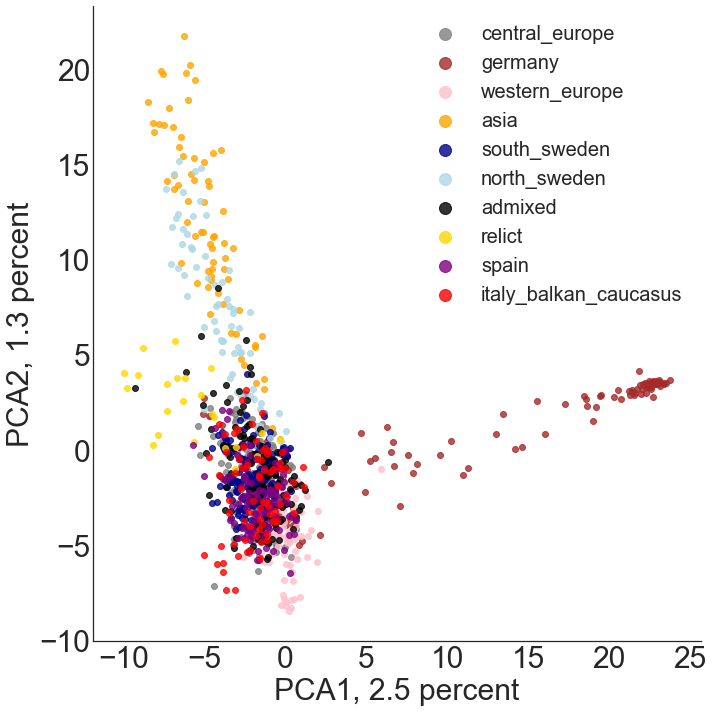

removed groups: ['germany']


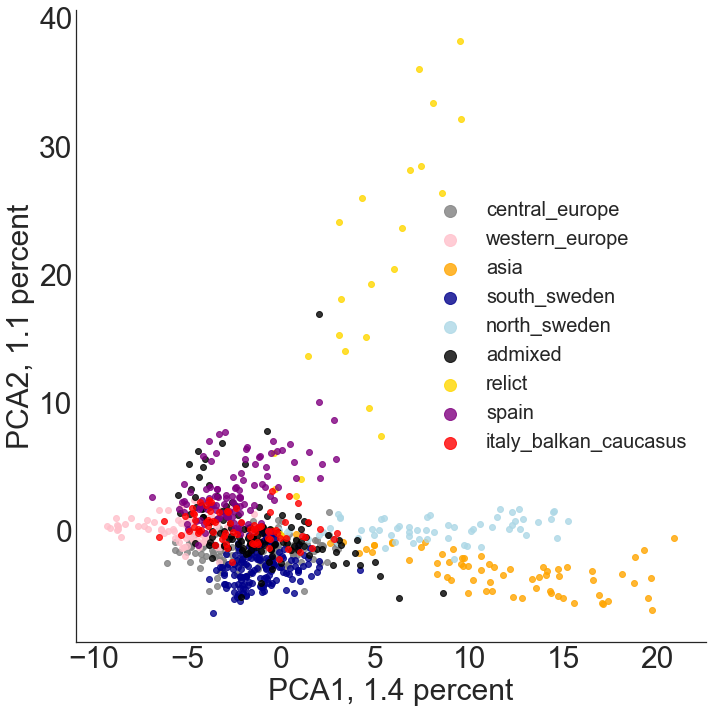

removed groups: ['germany', 'asia']


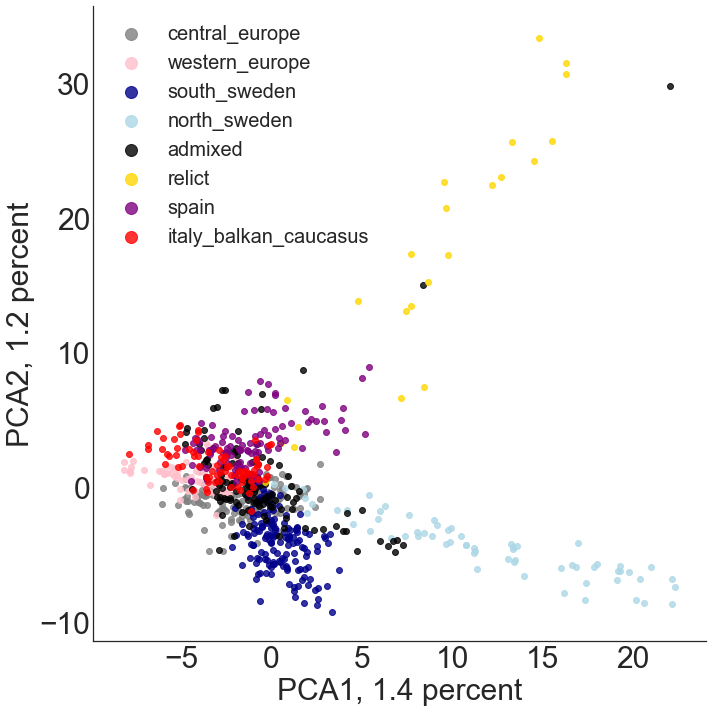

removed groups: ['germany', 'asia', 'relict']


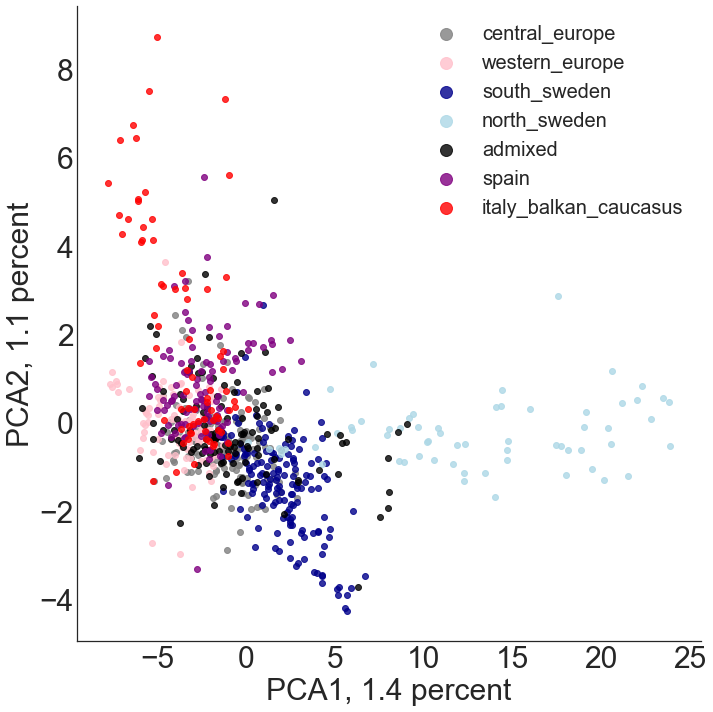

removed groups: ['germany', 'asia', 'relict', 'north_sweden']


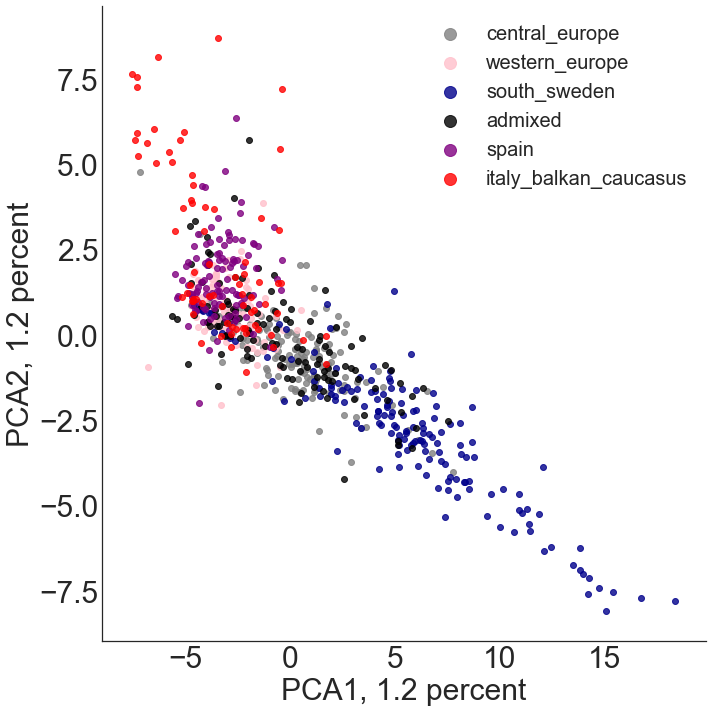

removed groups: ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden']


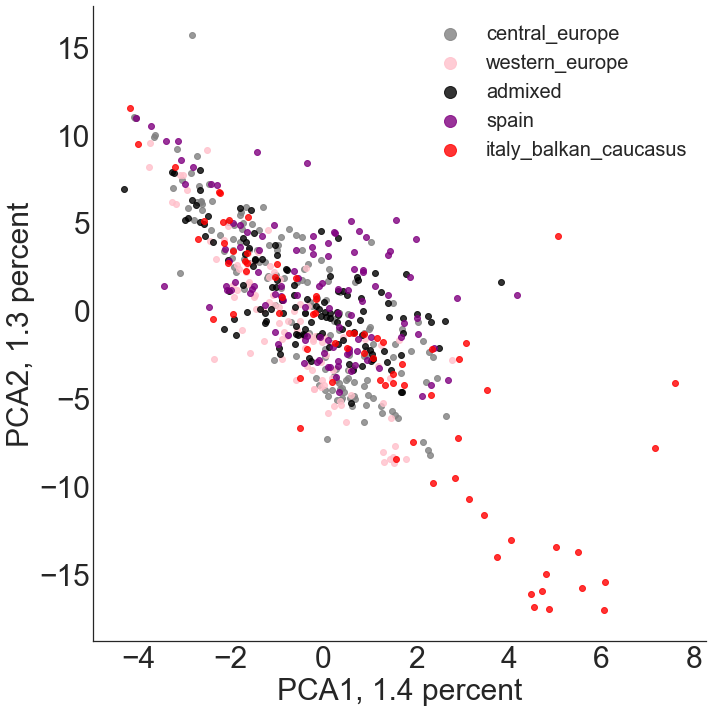

removed groups: ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden', 'italy_balkan_caucasus']


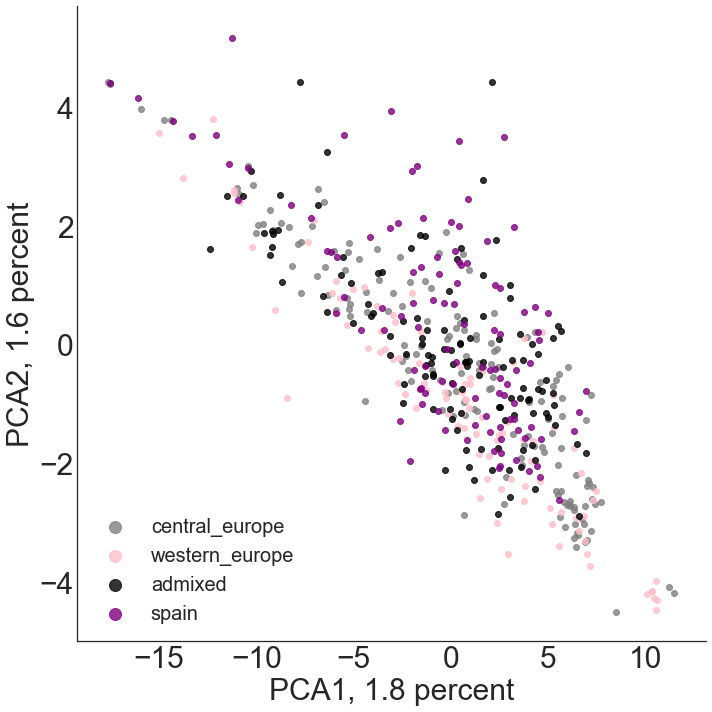

removed groups: ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden', 'italy_balkan_caucasus', 'central_europe']


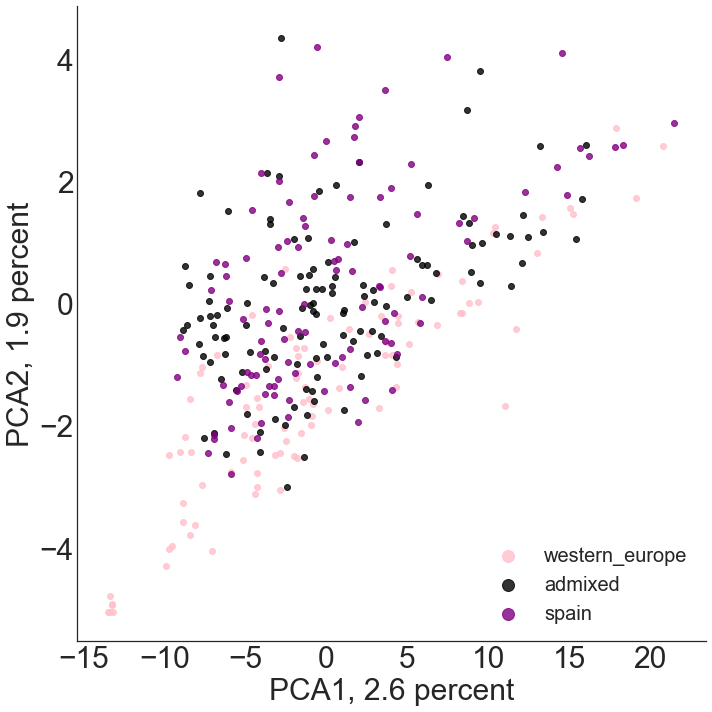

In [62]:
names = ['all', 'germany', 'germany_asia', 'germany_asia_relict', 
         'germany_asia_relict_ns', 'germany_asia_relict_ns_ss',
         'germany_asia_relict_ns_ss_ibc', 'germany_asia_relict_ns_ss_ibc_ce']
counter = -1
for group in [[''], ['germany'], ['germany', 'asia'], 
             ['germany', 'asia', 'relict'], 
             ['germany', 'asia', 'relict', 'north_sweden'],
             ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden'],
             ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden', 'italy_balkan_caucasus'],
             ['germany', 'asia', 'relict', 'north_sweden', 'south_sweden', 'italy_balkan_caucasus', 'central_europe']]:
        counter += 1
        print "removed groups:", group
        common_sub = common_X[~common_X['group'].isin(group)]

        X = common_sub.loc[:, 'chr1_10000548':]
        y = common_sub.group

        X = X.drop('group', axis = 1)
        X = X.dropna(axis = 1)
        standardisedX = scale(X)
        standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)
        pca = PCA().fit(standardisedX)

        # Summary
        summary = pca_summary(pca, standardisedX)
        pca1_perc_variance = summary.varprop.head(2).values[0][0]
        pca2_perc_variance = summary.varprop.head(2).values[1][0]

        # Frames for plotting
        foo = pca.transform(standardisedX)
        bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], y), columns=["PC1", "PC2", "Class"])
        
        # Dropping outliers
        max_PC1 = bar.sort_values(by = 'PC1').head(1).index[0]
        max_PC2 = bar.sort_values(by = 'PC2').head(1).index[0]
        min_PC1 = bar.sort_values(by = 'PC1', ascending = False).head(1).index[0]
        min_PC2 = bar.sort_values(by = 'PC2', ascending = False).head(1).index[0]
        bar = bar.drop([max_PC1, max_PC2, min_PC1, min_PC2])
        
        # Plotting
        lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False, size = 10, legend = False, 
               palette = {'asia' : 'Orange',
                          'central_europe' : 'Gray',
                          'germany' : 'Brown',
                          'italy_balkan_caucasus' : 'Red',
                          'north_sweden' : 'Lightblue',
                          'relict' : 'Gold',
                          'south_sweden' : 'Darkblue',
                          'spain' : 'purple',
                          'western_europe' : 'Pink',
                          'admixed' : 'Black'})
        ylabel('PCA2, %s percent' % round(pca2_perc_variance * 100, 1), size = 30)
        xlabel('PCA1, %s percent' % round(pca1_perc_variance * 100, 1), size = 30)
        xticks(size = 30)
        yticks(size = 30)
        legend(fontsize = 20, markerscale = 2)
        #title(names[counter])
        tight_layout()
        plt.savefig('../Figures/%s_PCA.png' % names[counter], format = 'png', transparent = True, dpi = 300)
        plt.savefig('../Figures/%s_PCA.pdf' % names[counter], format = 'pdf', transparent = True, dpi = 300)
        plt.show()

## SNP based PCA

In [37]:
f = h5py.File('../data/imputed_snps_binary.hdf5','r')

SNP [1 1 1 ..., 1 1 1]


In [44]:
groups_id = pd.read_csv('../data/1001genomes-accessions.csv')[['id', 'group']]
groups_id_dict = groups_id.set_index('id')['group'].to_dict()
y = [groups_id_dict[int(x)] for x in f['accessions'][:]]

PCA with 50,000 random SNPs

In [46]:
np.random.seed(10)
print "generating random indices ..."
random_indexes = choice(range(len(f['snps'])), 50000, replace = False)
print "making subset ..."
subset = f['snps'][list(sort(random_indexes))]

print "making dataframe ..."
X = pd.DataFrame(subset).T
y = [groups_id_dict[int(x)] for x in f['accessions'][:]]

print "fitting PCA ..."
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)
pca = PCA().fit(standardisedX)

generating random indices ...
making subset ...
making dataframe ...
fitting PCA ...


In [51]:
summary = pca_summary(pca, standardisedX)
pca1_perc_variance = summary.varprop.head(2).values[0][0]
pca2_perc_variance = summary.varprop.head(2).values[1][0]

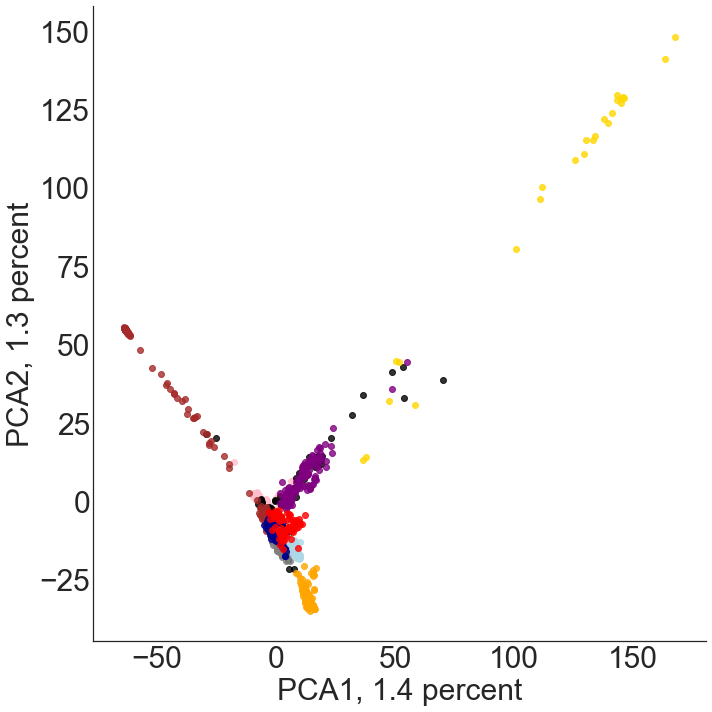

In [57]:
#f, ax = subplots()
foo = pca.transform(standardisedX)

bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], y), columns=["PC1", "PC2", "Class"])

lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False, size = 10, legend=False, 
       palette = {'asia' : 'Orange',
                  'central_europe' : 'Gray',
                  'germany' : 'Brown',
                  'italy_balkan_caucasus' : 'Red',
                  'north_sweden' : 'Lightblue',
                  'relict' : 'Gold',
                  'south_sweden' : 'Darkblue',
                  'spain' : 'purple',
                  'western_europe' : 'Pink',
                  'admixed' : 'Black'})
xticks(size = 30)
yticks(size = 30)

ylabel('PCA2, %s percent' % round(pca2_perc_variance * 100, 1), size = 30)
xlabel('PCA1, %s percent' % round(pca1_perc_variance * 100, 1), size = 30)
tight_layout()


savefig('../Figures/SNP_based_pop_structure_max30missing.pdf', format = 'pdf', transparent = True)
savefig('../Figures/SNP_based_pop_structure_max30missing.png', format = 'png', transparent = True, dpi = 300)

plt.show()